# Practice for 5511 GAN : Monet Painting


*June 2023*


### **Problem Statement**

The objective of this project is to build a GAN that generates 7,000 to 10,000 Monet-style images.



### **Data Source:**

https://www.kaggle.com/c/gan-getting-started/data


The data set includes 7363 files in 4 folders, and the details of each folder is as below:

* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 5 TFRecord files (300 Monet paintings sized 256x256 in TFRecord format)
* photo_jpg - 7038 photos sized 256x256 in JPEG format
* photo_tfrec - 20 TFRecord files (7038 photos sized 256x256 in TFRecord format)


### **Methodology**

A GAN will be built for this project. It will be consists of two neural networks: a generator model and a discriminator model.
Two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

And finally generate 7,000 to 10,000 Monet-style images with the model built.

By completing this project, we hope to enhance our knowledge of GAN and its applicability in real-world scenarios.

### **Detail steps** 


**1. Exploratory Data Analysis (EDA)** 

Firstly we will explore and visualize the data to understand the structure and distribution of the data.  

**2. Model Training & Evaluation**

Next, we will build GAN with training data set and check the performance on photo dataset. 
Different parameters in downsample() will be tried. 

1. Initialize the random weights for the convolutional layer: initializer = tf.random_normal_initializer(0., 0.02)
2. Enlarge the stdev to 0.2:  initializer = tf.random_normal_initializer(0., 0.2)
3. Change convolutional layer to separable convolutional layer: layers.Conv2D -->  layers.SeparableConv2D

**3. Conclusions**

Finally, we will summarize the results and see what can be improved in the future. 

In [32]:
# importing the necessary libraries:

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.12.0


#  EDA

### DATA LOADING

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()

# GCS_PATH = './data'

In [4]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [5]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [6]:
# Define the function to extract the image from the files.

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [7]:
# Load data

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

Let's  visualize some photo examples and some Monet example.

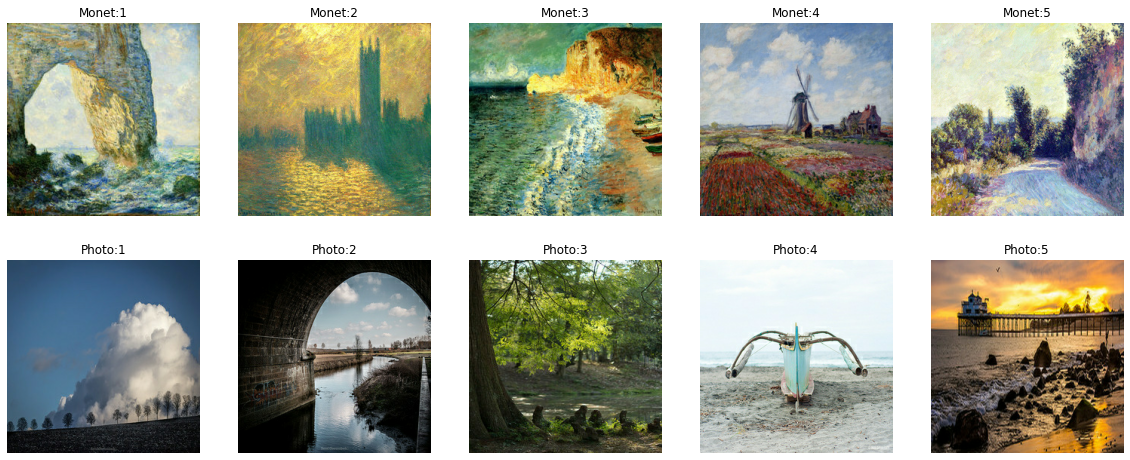

In [23]:
# Visualize the top 5 Monet images
plt.figure(figsize=(20, 8))
i = 0
for image in monet_ds.take(5):
    plt.subplot(2, 5, i+1)
    plt.title('Monet:' + str(i+1))
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.axis('off')
    i += 1

# plt.show()

# Visualize the top 5 images in Photo dataset
# plt.figure(figsize=(20, 8))
# i = 0
for image in photo_ds.take(5):
    plt.subplot(2, 5, i+1)
    plt.title('Photo:' + str(i-4))
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.axis('off')
    i += 1

plt.show()


### DATA DISTRIBUTION

Number of images in monet_ds: 300
Number of images in photo_ds: 7038


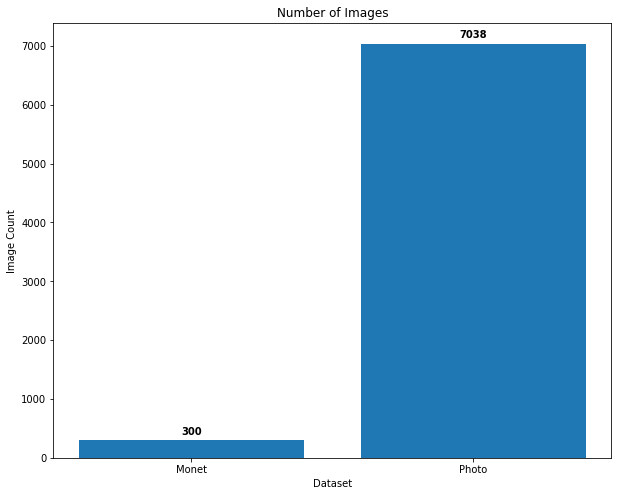

In [35]:
# Define a variable to count the number of images
monet_image_count = 0

# Loop through the dataset and count the number of images
for data in monet_ds:
    monet_image_count += 1

print("Number of images in monet_ds:", monet_image_count)

photo_image_count = 0

# Loop through the dataset and count the number of images
for data in photo_ds:
    photo_image_count += 1

print("Number of images in photo_ds:", photo_image_count)

# Create a barchart to show the number of images
# Define the labels
labels = ['Monet', 'Photo']

# Define the heights of the bars
heights = [monet_image_count, photo_image_count]

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.bar(labels, heights)

# Set the title and axis labels
plt.title('Number of Images')
plt.xlabel('Dataset')
plt.ylabel('Image Count')


# Add value labels to the top of each bar
for i, v in enumerate(heights):
    plt.text(i, v+100, str(v), color='black', ha='center', fontweight='bold')
# Display the chart
plt.show()


## Observations:

* There are 300 Monet images in traing data set and 7038 photos to be converted to Monet style. 

# MODELING AND EVALUATION

**In this work we will build GAN with training data set and check the performance on photo dataset.**

UNET architecture for CycleGAN will be applied. To build our generator, `downsample` and `upsample` methods need to be defined.
And different parameters in downsample() will be tried. 

1. Initialize the random weights for the convolutional layer: initializer = tf.random_normal_initializer(0., 0.02)
2. Enlarge the stdev to 0.2:  initializer = tf.random_normal_initializer(0., 0.2)
3. Change convolutional layer to separable convolutional layer: layers.Conv2D -->  layers.SeparableConv2D



### Define Downsample

In [36]:
# Define the number of output channels
OUTPUT_CHANNELS = 3

# Define the downsample function
def downsample(filters, size, apply_instancenorm=True):
    # Initialize the weights with random normal distribution
    initializer = tf.random_normal_initializer(0., 0.02)
    # Initialize the gamma parameter for InstanceNormalization with random normal distribution
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Create a sequential model
    result = keras.Sequential()

    # Add a convolutional layer to the model
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    # Check if InstanceNormalization should be applied
    if apply_instancenorm:
        # Add InstanceNormalization layer to the model
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    # Add LeakyReLU activation to the model
    result.add(layers.LeakyReLU())

    # Return the resulting model
    return result


### Define Upsample

In [37]:
# Define the upsample function
def upsample(filters, size, apply_dropout=False):
    # Initialize the weights with random normal distribution
    initializer = tf.random_normal_initializer(0., 0.02)
    # Initialize the gamma parameter for InstanceNormalization with random normal distribution
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Create a sequential model
    result = keras.Sequential()

    # Add a transpose convolutional layer to the model
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    # Add InstanceNormalization layer to the model
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    # Check if dropout should be applied
    if apply_dropout:
        # Add dropout layer to the model
        result.add(layers.Dropout(0.5))

    # Add ReLU activation to the model
    result.add(layers.ReLU())

    # Return the resulting model
    return result


### Build the Generator

In [38]:
# Build the Generator

def Generator():
    inputs = layers.Input(shape=[256,256,3])  # Define input shape for the generator model

    # Define the downsampling layers
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # Downsample with 64 filters, kernel size 4, and no instance normalization. Output: (bs, 128, 128, 64)
        downsample(128, 4),  # Downsample with 128 filters and kernel size 4. Output: (bs, 64, 64, 128)
        downsample(256, 4),  # Downsample with 256 filters and kernel size 4. Output: (bs, 32, 32, 256)
        downsample(512, 4),  # Downsample with 512 filters and kernel size 4. Output: (bs, 16, 16, 512)
        downsample(512, 4),  # Downsample with 512 filters and kernel size 4. Output: (bs, 8, 8, 512)
        downsample(512, 4),  # Downsample with 512 filters and kernel size 4. Output: (bs, 4, 4, 512)
        downsample(512, 4),  # Downsample with 512 filters and kernel size 4. Output: (bs, 2, 2, 512)
        downsample(512, 4),  # Downsample with 512 filters and kernel size 4. Output: (bs, 1, 1, 512)
    ]

    # Define the upsampling layers
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # Upsample with 512 filters, kernel size 4, and apply dropout. Output: (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # Upsample with 512 filters, kernel size 4, and apply dropout. Output: (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # Upsample with 512 filters, kernel size 4, and apply dropout. Output: (bs, 8, 8, 1024)
        upsample(512, 4),  # Upsample with 512 filters and kernel size 4. Output: (bs, 16, 16, 1024)
        upsample(256, 4),  # Upsample with 256 filters and kernel size 4. Output: (bs, 32, 32, 512)
        upsample(128, 4),  # Upsample with 128 filters and kernel size 4. Output: (bs, 64, 64, 256)
        upsample(64, 4),  # Upsample with 64 filters and kernel size 4. Output: (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)  # Define an initializer for the convolutional layers
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # Final convolutional layer. Output: (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x) # Store the output of each downsampling layer for skip connections
        
    skips = reversed(skips[:-1])  # Reverse the skips list, excluding the last element

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)  # Upsample the input
        x = layers.Concatenate()([x, skip])  # Concatenate the upsampled input with the corresponding skip connection

    x = last(x)  # Apply the final convolutional layer

    return keras.Model(inputs=inputs, outputs=x)  # Return the generator model with the defined inputs and outputs


### Build the Discriminator

In [39]:
# Build the discriminator

def Discriminator():
    # Initialize the random normal initializer for weights and the gamma initializer for instance normalization
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # Define the input shape for the discriminator model
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    # Downsample the input image using a convolutional layer with 64 filters and kernel size 4, without applying instance normalization
    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)

    # Downsample the previous layer output using a convolutional layer with 128 filters and kernel size 4
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)

    # Downsample the previous layer output using a convolutional layer with 256 filters and kernel size 4
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    # Pad the previous layer output with zero padding
    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)

    # Apply a convolutional layer with 512 filters, kernel size 4, and no bias
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    # Apply instance normalization to the previous layer output using the gamma initializer
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    # Apply a leaky ReLU activation function to the previous layer output
    leaky_relu = layers.LeakyReLU()(norm1)

    # Pad the previous layer output with zero padding
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    # Apply a convolutional layer with 1 filter, kernel size 4
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    # Return the discriminator model with the defined inputs and outputs
    return tf.keras.Model(inputs=inp, outputs=last)


In [40]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

### Build the CycleGAN model

In [42]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator  # Monet generator model
        self.p_gen = photo_generator  # Photo generator model
        self.m_disc = monet_discriminator  # Monet discriminator model
        self.p_disc = photo_discriminator  # Photo discriminator model
        self.lambda_cycle = lambda_cycle  # Weight for cycle consistency loss
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer  # Monet generator optimizer
        self.p_gen_optimizer = p_gen_optimizer  # Photo generator optimizer
        self.m_disc_optimizer = m_disc_optimizer  # Monet discriminator optimizer
        self.p_disc_optimizer = p_disc_optimizer  # Photo discriminator optimizer
        self.gen_loss_fn = gen_loss_fn  # Generator loss function
        self.disc_loss_fn = disc_loss_fn  # Discriminator loss function
        self.cycle_loss_fn = cycle_loss_fn  # Cycle consistency loss function
        self.identity_loss_fn = identity_loss_fn  # Identity loss function
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)  # Generate Monet-esque photo from real photo
            cycled_photo = self.p_gen(fake_monet, training=True)  # Generate reconstructed photo from fake Monet-esque photo

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)  # Generate photo from real Monet-esque photo
            cycled_monet = self.m_gen(fake_photo, training=True)  # Generate reconstructed Monet-esque photo from fake photo

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)  # Generate Monet-esque photo from real Monet-esque photo
            same_photo = self.p_gen(real_photo, training=True)  # Generate photo from real photo

            # discriminator used to check, inputting real images
            disc_real_monet = self.m_disc(real_monet, training=True)  # Discriminator output for real Monet-esque photo
            disc_real_photo = self.p_disc(real_photo, training=True)  # Discriminator output for real photo

            # discriminator used to check, inputting fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)  # Discriminator output for fake Monet-esque photo
            disc_fake_photo = self.p_disc(fake_photo, training=True)  # Discriminator output for fake photo

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)  # Generator loss based on fake Monet-esque photo
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)  # Generator loss based on fake photo

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)  # Discriminator loss based on real and fake Monet-esque photos
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)  # Discriminator loss based on real and fake photos

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


### Define loss functions

In [43]:
with strategy.scope():
    def discriminator_loss(real, generated):
        # Compute the binary cross-entropy loss between the true labels (ones) and the discriminator's predictions for real images
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        
        # Compute the binary cross-entropy loss between the false labels (zeros) and the discriminator's predictions for generated images
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        
        # Compute the total discriminator loss by summing the losses for real and generated images
        total_disc_loss = real_loss + generated_loss
        
        # Return the average of the total discriminator loss, scaled by 0.5
        return total_disc_loss * 0.5
        

In [44]:
with strategy.scope():
    def generator_loss(generated):
        # Compute the binary cross-entropy loss between the true labels (ones) and the discriminator's predictions for generated images
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        

In [45]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        # Calculate the mean absolute difference between the real image and the cycled image
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        
        # Scale the loss by the value of LAMBDA and return the result
        return LAMBDA * loss1

In [46]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        # Calculate the mean absolute difference between the real image and the same image
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        
        # Scale the loss by the value of LAMBDA multiplied by 0.5 and return the result
        return LAMBDA * 0.5 * loss


### Train the CycleGAN (1st Try)

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [47]:
with strategy.scope():
    # Define an Adam optimizer for the monet generator with a learning rate of 2e-4 and beta_1 value of 0.5
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    # Define an Adam optimizer for the photo generator with a learning rate of 2e-4 and beta_1 value of 0.5
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    # Define an Adam optimizer for the monet discriminator with a learning rate of 2e-4 and beta_1 value of 0.5
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    # Define an Adam optimizer for the photo discriminator with a learning rate of 2e-4 and beta_1 value of 0.5
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [48]:
with strategy.scope():
    # Create an instance of the CycleGan model
    cycle_gan_model = CycleGan(
        monet_generator,            # Monet generator model
        photo_generator,            # Photo generator model
        monet_discriminator,        # Monet discriminator model
        photo_discriminator         # Photo discriminator model
    )

    # Compile the CycleGan model with the specified optimizers and loss functions
    cycle_gan_model.compile(
        m_gen_optimizer=monet_generator_optimizer,        # Optimizer for the Monet generator
        p_gen_optimizer=photo_generator_optimizer,        # Optimizer for the photo generator
        m_disc_optimizer=monet_discriminator_optimizer,   # Optimizer for the Monet discriminator
        p_disc_optimizer=photo_discriminator_optimizer,   # Optimizer for the photo discriminator
        gen_loss_fn=generator_loss,                        # Loss function for the generator
        disc_loss_fn=discriminator_loss,                   # Loss function for the discriminator
        cycle_loss_fn=calc_cycle_loss,                      # Loss function for the cycle consistency
        identity_loss_fn=identity_loss                      # Loss function for the identity loss
    )


In [23]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25


2023-05-31 15:20:15.395972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 193s 437ms/step - monet_gen_loss: 5.2871 - photo_gen_loss: 5.4534 - monet_disc_loss: 0.6431 - photo_disc_loss: 0.6213
Epoch 2/25
300/300 [==============================] - 136s 442ms/step - monet_gen_loss: 3.7302 - photo_gen_loss: 3.9967 - monet_disc_loss: 0.6577 - photo_disc_loss: 0.5447
Epoch 3/25
300/300 [==============================] - 135s 442ms/step - monet_gen_loss: 3.7124 - photo_gen_loss: 3.9177 - monet_disc_loss: 0.6284 - photo_disc_loss: 0.5964
Epoch 4/25
300/300 [==============================] - 135s 441ms/step - monet_gen_loss: 3.6678 - photo_gen_loss: 3.8892 - monet_disc_loss: 0.6221 - photo_disc_loss: 0.5867
Epoch 5/25
300/300 [==============================] - 135s 441ms/step - monet_gen_loss: 3.5079 - photo_gen_loss: 3.6096 - monet_disc_loss: 0.6190 - photo_disc_loss: 0.6074
Epoch 6/25
300/300 [==============================] - 136s 442ms/step - monet_gen_loss: 3.3835 - photo_gen_loss: 3.4890 - monet_disc_loss: 0.6210 - pho

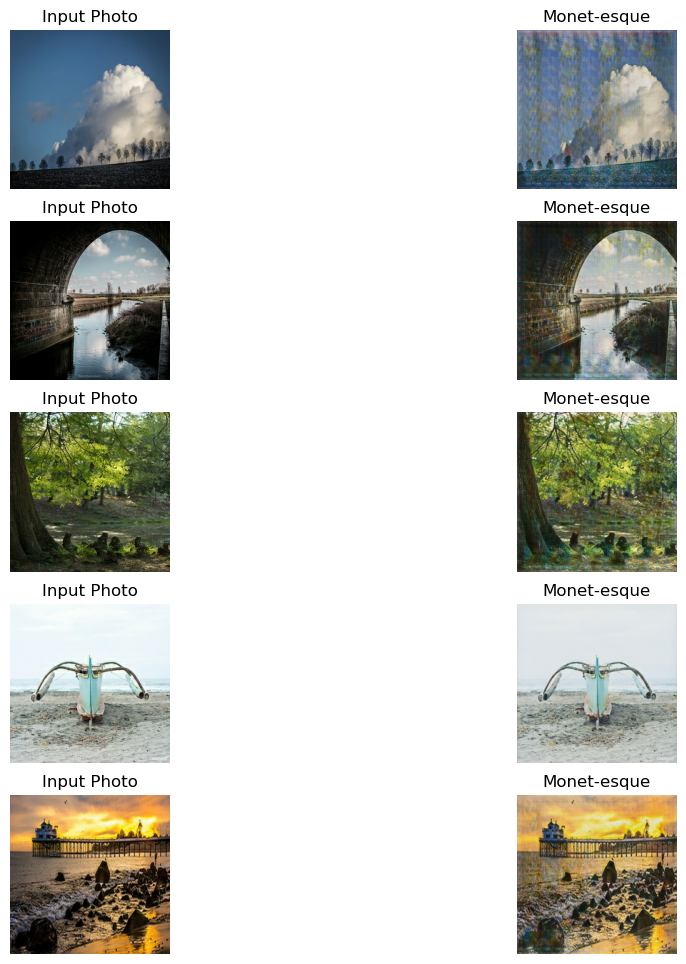

In [24]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [25]:
import PIL
! mkdir ../images

In [26]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [27]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# 2nd Try

Change the parameters in downsample() 

* Enlarge the stdev from 0.02 to 0.2:  initializer = tf.random_normal_initializer(0., 0.2)

In [10]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.2)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.2)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [20]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [21]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [23]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25


2023-06-04 01:56:24.461214: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 198s 450ms/step - monet_gen_loss: 4.2873 - photo_gen_loss: 4.3422 - monet_disc_loss: 0.6324 - photo_disc_loss: 0.6542
Epoch 2/25
300/300 [==============================] - 138s 457ms/step - monet_gen_loss: 3.1479 - photo_gen_loss: 3.1333 - monet_disc_loss: 0.6194 - photo_disc_loss: 0.6395
Epoch 3/25
300/300 [==============================] - 137s 456ms/step - monet_gen_loss: 2.9392 - photo_gen_loss: 2.8877 - monet_disc_loss: 0.5993 - photo_disc_loss: 0.6228
Epoch 4/25
300/300 [==============================] - 137s 456ms/step - monet_gen_loss: 2.8181 - photo_gen_loss: 2.7648 - monet_disc_loss: 0.5990 - photo_disc_loss: 0.6159
Epoch 5/25
300/300 [==============================] - 138s 457ms/step - monet_gen_loss: 2.7444 - photo_gen_loss: 2.6972 - monet_disc_loss: 0.5947 - photo_disc_loss: 0.6069
Epoch 6/25
300/300 [==============================] - 137s 456ms/step - monet_gen_loss: 2.7052 - photo_gen_loss: 2.6631 - monet_disc_loss: 0.5881 - pho

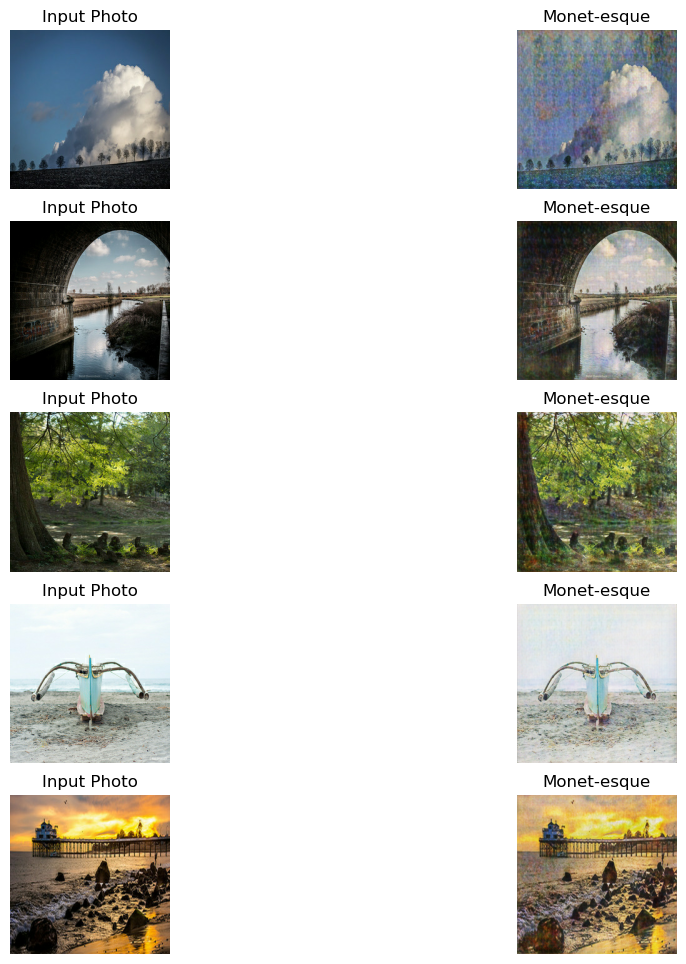

In [24]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [25]:
import PIL
! mkdir ../images

In [26]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [27]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# 3rd Try

Revise downsample() 

* Change convolutional layer to separable convolutional layer: layers.Conv2D -->  layers.SeparableConv2D

Useing layers.SeparableConv2D for downsampling, which performs depthwise separable convolution. It separates the spatial convolution and channel-wise convolution into two separate layers, reducing the number of parameters and computation. It is more computationally efficient than standard convolution.

In [10]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.2)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

    result = keras.Sequential()
    # Change convolutional layer to separable convolutional layer: layers.Conv2D --> layers.SeparableConv2D
    result.add(layers.SeparableConv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.2)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [12]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [14]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [17]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [18]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [19]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [20]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [21]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [23]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25


2023-06-04 09:40:58.051247: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 163s 317ms/step - monet_gen_loss: 6.0911 - photo_gen_loss: 6.1923 - monet_disc_loss: 0.6360 - photo_disc_loss: 0.6107
Epoch 2/25
300/300 [==============================] - 96s 319ms/step - monet_gen_loss: 4.1178 - photo_gen_loss: 4.1710 - monet_disc_loss: 0.6141 - photo_disc_loss: 0.6211
Epoch 3/25
300/300 [==============================] - 96s 319ms/step - monet_gen_loss: 3.8080 - photo_gen_loss: 3.8393 - monet_disc_loss: 0.6314 - photo_disc_loss: 0.6367
Epoch 4/25
300/300 [==============================] - 96s 320ms/step - monet_gen_loss: 3.6216 - photo_gen_loss: 3.6706 - monet_disc_loss: 0.6462 - photo_disc_loss: 0.6287
Epoch 5/25
300/300 [==============================] - 96s 319ms/step - monet_gen_loss: 3.5535 - photo_gen_loss: 3.5829 - monet_disc_loss: 0.6366 - photo_disc_loss: 0.6277
Epoch 6/25
300/300 [==============================] - 96s 319ms/step - monet_gen_loss: 3.5093 - photo_gen_loss: 3.5281 - monet_disc_loss: 0.6300 - photo_di

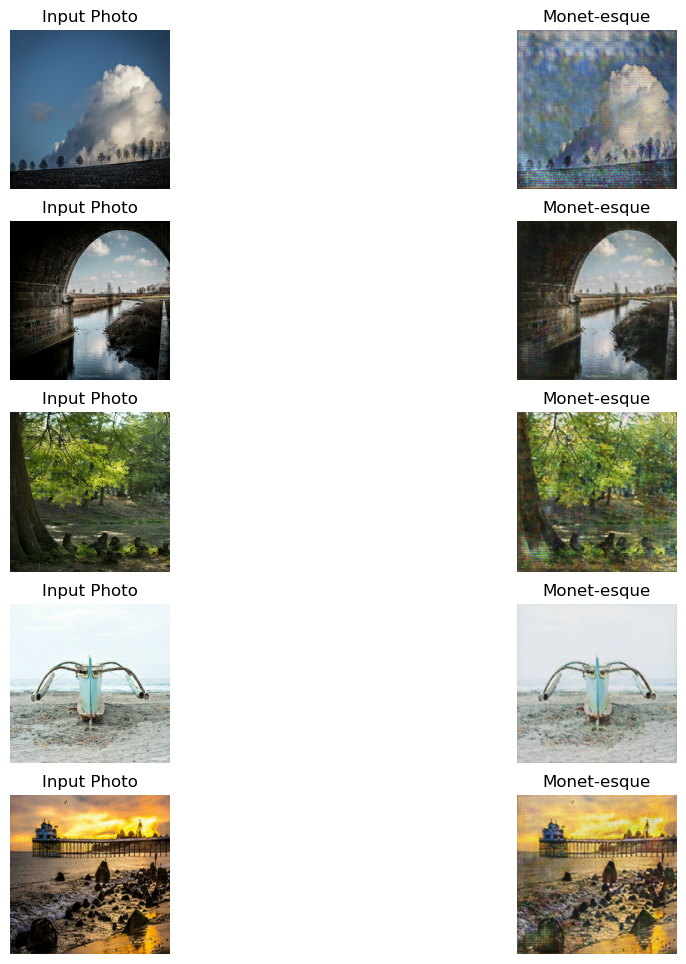

In [24]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [25]:
import PIL
! mkdir ../images

In [26]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [27]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

______ 
# Result

Here are the scores received after submitting result to Kaggle. 


| submission file | Architecture Detail                                                         | Score                       |
|-----------------|-----------------------------------------------------------------------------|-----------------------------|
| Version 6       | 3rd Try, change layers.Conv2D -->    layers.SeparableConv2D in downsample() | 51.26233 (rank 33 out of 90)|
| Version 5       | 2nd Try, enlarge stdev from 0.02 to 0.2 in downdample()                     | 54.73067 (rank 35 out of 90)|
| Version 2       | 1st Try, default setting from Tutorial                                      | 56.29089 (rank 38 out of 90)|

As we can see from the result, the default seting from the Tutorial alreay achieved pretty good result (rank 38 out of 90).
After modify downdample(), the performance got slightly improved (score changed from 56.29 to 51.26, rank improved from 38 to 33)


The reason of useing layers.SeparableConv2D for downsampling is because it's more computationally efficient than standard convolution.

The score is still far from the top plays. So the **next step** is to further fine tune the hyperparameters and also try other architectures such DCGAN.



### Snapshot from Kaggle for reference

![alt text](kaggle_submission_snapshot.png "Solution Score")